# Importing Libraries

In [153]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import os.path
from pathlib import Path
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing import image
from PIL import Image

## Loading Data

In [154]:
 #Selecting Dataset Folder Paths
f_dir_ = Path('data/femaleeyes')
m_dir_ = Path('data/maleeyes')
femaleeyes_filepaths = list(f_dir_.glob(r'**/*.jpg'))
maleeyes_filepaths = list(m_dir_.glob(r'**/*.jpg'))

# Mapping the labels
fm_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], femaleeyes_filepaths))
ml_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], maleeyes_filepaths))

# Paths & labels femalee eyes
fm_filepaths = pd.Series(femaleeyes_filepaths, name = 'File').astype(str)
fm_labels = pd.Series(fm_labels, name='Label')

# Paths & labels male eyes
ml_filepaths = pd.Series(maleeyes_filepaths, name = 'File').astype(str)
ml_labels = pd.Series(ml_labels, name='Label')

# Concatenating...
femaleeyes_df = pd.concat([fm_filepaths, fm_labels], axis=1)
maleeyes_df = pd.concat([ml_filepaths, ml_labels], axis=1)

df = pd.concat([femaleeyes_df, maleeyes_df])

df = df.sample(frac = 1, random_state = 56).reset_index(drop = True)

# EDA

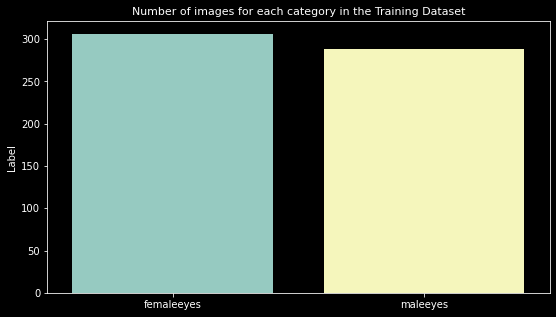

In [155]:
vc = df['Label'].value_counts()
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc)
plt.title("Number of images for each category in the Training Dataset", fontsize = 11)
plt.show()

In [156]:
plt.style.use("dark_background")

Text(0.5, 1.0, 'maleeyes')

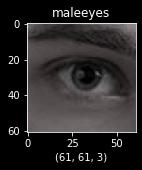

In [157]:
figure = plt.figure(figsize=(2,2))
x = plt.imread(df["File"][34])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][34])

Text(0.5, 1.0, 'femaleeyes')

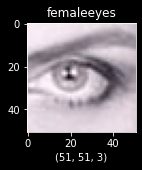

In [158]:
figure = plt.figure(figsize=(2, 2))
x = plt.imread(df["File"][11])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][11])

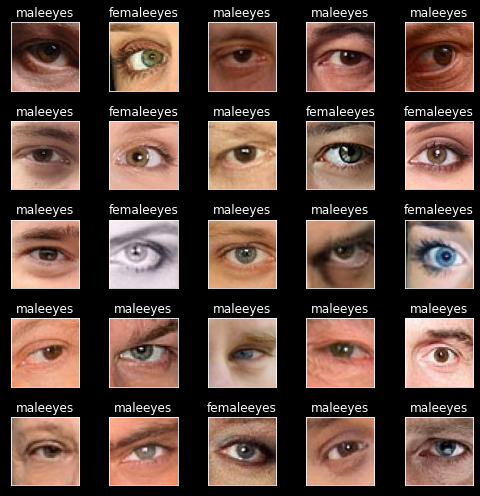

In [159]:
fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["File"][i]))
    ax.set_title(df["Label"][i])
plt.tight_layout()
plt.show()

### Splitting into traiset & testset.

In [160]:
trainset_df, testset_df = train_test_split(df, train_size = 0.75, random_state = 4)

display(trainset_df.head())

testset_df.head()

,File,Label
103,data\maleeyes\2651.jpg,maleeyes
565,data\maleeyes\493.jpg,maleeyes
528,data\femaleeyes\3372.jpg,femaleeyes
389,data\femaleeyes\3320.jpg,femaleeyes
519,data\maleeyes\2672.jpg,maleeyes


,File,Label
441,data\maleeyes\557.jpg,maleeyes
325,data\femaleeyes\3415.jpg,femaleeyes
541,data\femaleeyes\320.jpg,femaleeyes
463,data\maleeyes\546.jpg,maleeyes
268,data\femaleeyes\3429.jpg,femaleeyes


In [161]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [162]:
#Class to load the dataset images from drivce
import os
import cv2
import numpy as np


class SimpleDatasetLoader:
    # Method: Constructor
    def __init__(self, preprocessors=None):
        """
        :param preprocessors: List of image preprocessors
        """
        self.preprocessors = preprocessors

        if self.preprocessors is None:
            self.preprocessors = []

    # Method: Used to load a list of images for pre-processing
    def load(self, image_paths, verbose=-1):
        """
        :param image_paths: List of image paths
        :param verbose: Parameter for printing information to console
        :return: Tuple of data and labels
        """
        data, labels = [], []

        for i, image_path in enumerate(image_paths):
            image = cv2.imread(image_path)
            label = image_path.split(os.path.sep)[-2]

            if self.preprocessors is not None:
                for p in self.preprocessors:
                    image = p.preprocess(image)

            data.append(image)
            labels.append(label)

            if verbose > 0 and i > 0 and (i+1) % verbose == 0:
                print('[INFO]: Processed {}/{}'.format(i+1, len(image_paths)))

        return (np.array(data), np.array(labels))

In [163]:
#Class Preprocessror 
class SimplePreprocessor:
    # Method: Constructor
    def __init__(self, width, height, interpolation=cv2.INTER_AREA):
        """
        :param width: Image width
        :param height: Image height
        :param interpolation: Interpolation algorithm
        """
        self.width = width
        self.height = height
        self.interpolation = interpolation

    # Method: Used to resize the image to a fixed size (ignoring the aspect ratio)
    def preprocess(self, image):
        """
        :param image: Image
        :return: Re-sized image
        """
        return cv2.resize(image, (self.width, self.height), interpolation=self.interpolation)

# KNN classifier

In [164]:
from imutils import paths
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from __main__ import SimplePreprocessor
from __main__ import SimpleDatasetLoader

# Get list of image paths
image_paths = list(paths.list_images("data"))

# Initialize SimplePreprocessor and SimpleDatasetLoader and load data and labels
print('[INFO]: Images loading....')
sp = SimplePreprocessor(32, 32)
sdl = SimpleDatasetLoader(preprocessors=[sp])
(data, labels) = sdl.load(image_paths, verbose=500)

# Reshape from (3000, 32, 32, 3) to (3000, 32*32*3=3072)
data = data.reshape((data.shape[0], 3072))

# Print information about memory consumption
print('[INFO]: Features Matrix: {:.1f}MB'.format(float(data.nbytes / 1024*1000.0)))

# Encode labels as integers
le = LabelEncoder()
labels = le.fit_transform(labels)

# Split data into training (75%) and testing (25%) data
(train_x, test_x, train_y, test_y) = train_test_split(data, labels, test_size=0.25, random_state=42)

# Train and evaluate the k-NN classifier on the raw pixel intensities
print('[INFO]: Classification starting....')
model = KNeighborsClassifier(n_neighbors=7,
                             n_jobs=1,algorithm='kd_tree')
model.fit(train_x, train_y)
print(classification_report(test_y, model.predict(test_x),
                            target_names=le.classes_))

[INFO]: Images loading....
[INFO]: Processed 500/594
[INFO]: Features Matrix: 1782000.0MB
[INFO]: Classification starting....
              precision    recall  f1-score   support

  femaleeyes       0.71      0.65      0.68        84
    maleeyes       0.60      0.66      0.63        65

    accuracy                           0.66       149
   macro avg       0.66      0.66      0.66       149
weighted avg       0.66      0.66      0.66       149



# MLP Model

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 

eyes = os.listdir('data')
print(eyes)

print("Types of eyes found: ",len(eyes))


['femaleeyes', 'maleeyes']
Types of eyes found:  2


In [166]:
eye = []

for item in eyes:
    all_eyes = os.listdir('data' + '/' + item)
    
    for eye_ in all_eyes:
        eye.append((item, str('data' + '/' + item) + '/' + eye_))
        print(eye[:1])

[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes/235.jpg')]
[('femaleeyes', 'data/femaleeyes

In [167]:
eye_df = pd.DataFrame(data=eye, columns=['eye_type', 'image'])
print(eye_df.head())
print(eye_df.tail())

     eye_type                    image
0  femaleeyes  data/femaleeyes/235.jpg
1  femaleeyes  data/femaleeyes/237.jpg
2  femaleeyes  data/femaleeyes/238.jpg
3  femaleeyes  data/femaleeyes/242.jpg
4  femaleeyes  data/femaleeyes/243.jpg
     eye_type                  image
589  maleeyes  data/maleeyes/557.jpg
590  maleeyes  data/maleeyes/558.jpg
591  maleeyes  data/maleeyes/559.jpg
592  maleeyes  data/maleeyes/560.jpg
593  maleeyes  data/maleeyes/561.jpg


In [168]:
print("Total Number of Eyes: ",len(eye_df))

Total Number of Eyes:  594


In [169]:
eye_count = eye_df['eye_type'].value_counts()

print("Eyes in each category: ")
print(eye_count)

Eyes in each category: 
femaleeyes    306
maleeyes      288
Name: eye_type, dtype: int64


In [170]:
import cv2
path = 'data/'

im_size = 300

images = []
labels = []

for i in eyes:
    data_path = path + str(i)
    filenames = [i for i in os.listdir(data_path)]
    
    for f in filenames:
        img = cv2.imread(data_path + '/' +f)
        img = cv2.resize(img, (im_size, im_size))
        images.append(img)
        labels.append(i)

In [171]:
images = np.array(images)

images.shape

(594, 300, 300, 3)

In [172]:
images = images.astype('float16') / 255.0

In [173]:
images.shape

(594, 300, 300, 3)

In [174]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder

y=eye_df['eye_type'].values
y_labelencoder = LabelEncoder()
y = y_labelencoder.fit_transform(y)
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [175]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

images, y =shuffle(images, y, random_state=1)

train_x, test_x, train_y, test_y = train_test_split(images, y, test_size=0.05, random_state=42)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(564, 300, 300, 3)
(564,)
(30, 300, 300, 3)
(30,)


In [176]:
import keras
import tensorflow as tf
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(300,300,3)),
    keras.layers.Dense(256, activation=tf.nn.tanh),
    
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [177]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 270000)            0         
                                                                 
 dense_12 (Dense)            (None, 256)               69120256  
                                                                 
 dense_13 (Dense)            (None, 3)                 771       
                                                                 
Total params: 69,121,027
Trainable params: 69,121,027
Non-trainable params: 0
_________________________________________________________________


In [178]:
model.compile(optimizer=tf.optimizers.Adam(),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [179]:
history = model.fit(train_x, train_y,validation_split=0.2, epochs=50)

Epoch 1/50
15/15 [==============================] - 5s 272ms/step - loss: 5.0697 - accuracy: 0.5211 - val_loss: 3.2363 - val_accuracy: 0.5575
Epoch 2/50
15/15 [==============================] - 4s 253ms/step - loss: 1.9667 - accuracy: 0.5188 - val_loss: 0.7074 - val_accuracy: 0.4425
Epoch 3/50
15/15 [==============================] - 4s 235ms/step - loss: 0.9097 - accuracy: 0.4812 - val_loss: 0.7849 - val_accuracy: 0.4425
Epoch 4/50
15/15 [==============================] - 4s 238ms/step - loss: 0.7258 - accuracy: 0.5033 - val_loss: 0.7096 - val_accuracy: 0.5575
Epoch 5/50
15/15 [==============================] - 4s 239ms/step - loss: 0.7069 - accuracy: 0.5122 - val_loss: 0.7045 - val_accuracy: 0.4425
Epoch 6/50
15/15 [==============================] - 3s 231ms/step - loss: 0.6934 - accuracy: 0.5011 - val_loss: 0.6866 - val_accuracy: 0.5575
Epoch 7/50
15/15 [==============================] - 3s 222ms/step - loss: 0.6980 - accuracy: 0.5188 - val_loss: 0.6912 - val_accuracy: 0.5575
Epoch 

### Plotting Model Accuracy & Loss

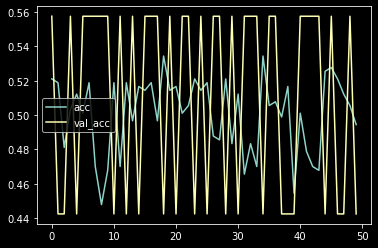

<Figure size 432x288 with 0 Axes>

In [180]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

### Plotting Model Loss & Validation Loss

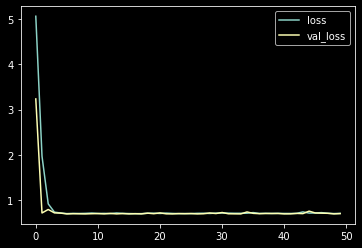

<Figure size 432x288 with 0 Axes>

In [181]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plt.jpg")

In [182]:
# predict probabilities for test set
yhat_probs = model.predict(test_x, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(model.predict(test_x), axis=-1)

In [183]:
# accuracy
accuracy = accuracy_score(test_y, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision 
precision = precision_score(test_y, yhat_classes)
print('Precision: %f' % precision)
# recall
recall = recall_score(test_y, yhat_classes)
print('Recall: %f' % recall)
# f1
f1 = f1_score(test_y, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.700000
Precision: 0.700000
Recall: 1.000000
F1 score: 0.823529


# CNN model

CNN model with 4 CNN layers, no dropout.

In [184]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l1_l2
from tensorflow.keras.layers import BatchNormalization

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(300, 300, 3)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 300, 300, 32)      896       
                                                                 
 conv2d_17 (Conv2D)          (None, 298, 298, 32)      9248      
                                                                 
 batch_normalization_12 (Bat  (None, 298, 298, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 149, 149, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 149, 149, 64)      18496     
                                                                 
 batch_normalization_13 (Bat  (None, 149, 149, 64)    

In [185]:
model.compile(optimizer=tf.optimizers.Adam(),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [186]:
train_x,x_validate,train_y,y_validate = train_test_split(train_x,train_y,test_size = 0.2,random_state = 12345)

In [187]:
history = model.fit(
    train_x,
    train_y,
    epochs=30,
    verbose=1,
    validation_data=(x_validate,y_validate),
)

Epoch 1/30
15/15 [==============================] - 63s 4s/step - loss: 69.2077 - accuracy: 0.6098 - val_loss: 2.6663 - val_accuracy: 0.4513
Epoch 2/30
15/15 [==============================] - 59s 4s/step - loss: 13.9606 - accuracy: 0.7428 - val_loss: 1.4740 - val_accuracy: 0.5841
Epoch 3/30
15/15 [==============================] - 61s 4s/step - loss: 6.4961 - accuracy: 0.8315 - val_loss: 1.5576 - val_accuracy: 0.5575
Epoch 4/30
15/15 [==============================] - 61s 4s/step - loss: 5.4487 - accuracy: 0.8271 - val_loss: 3.2981 - val_accuracy: 0.4336
Epoch 5/30
15/15 [==============================] - 62s 4s/step - loss: 9.2480 - accuracy: 0.7672 - val_loss: 2.9176 - val_accuracy: 0.4425
Epoch 6/30
15/15 [==============================] - 62s 4s/step - loss: 5.0349 - accuracy: 0.8137 - val_loss: 8.2940 - val_accuracy: 0.4336
Epoch 7/30
15/15 [==============================] - 63s 4s/step - loss: 2.4857 - accuracy: 0.8581 - val_loss: 8.7410 - val_accuracy: 0.4336
Epoch 8/30
15/15 [

### Model Accuracy and Loss, and Validation Accuracy and Loss

Text(0.5, 1.0, 'Train - Accuracy')

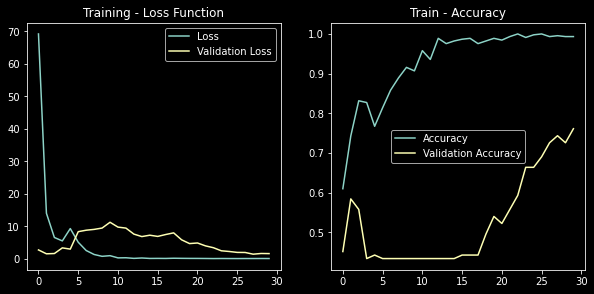

In [188]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [189]:
# predict probabilities for test set
yhat_probs = model.predict(test_x, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(model.predict(test_x), axis=-1)

In [190]:
# accuracy
accuracy = accuracy_score(test_y, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision 
precision = precision_score(test_y, yhat_classes)
print('Precision: %f' % precision)
# recall
recall = recall_score(test_y, yhat_classes)
print('Recall: %f' % recall)
# f1
f1 = f1_score(test_y, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.933333
Precision: 0.952381
Recall: 0.952381
F1 score: 0.952381


# Conclusion

The benchmark model using KNN got accuracy of 66%.<br>
The MLP model got accuracy of 70%.<br>
The CNN model got accuracy of 93%.

The experement shows that MLP and CNN are better to classify images.